In [1]:
# Useful libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

# Download Moving-MNIST dataset
!wget 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

# Custom metrics
def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)
def ssim(y_gt, y_pred, max_val=1.):
  return tf.image.ssim(y_gt, y_pred, max_val)
def psnr(y_gt, y_pred, max_val=1.):
  return tf.image.psnr(y_gt, y_pred, max_val)

--2020-05-31 01:26:03--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy’

mnist_test_seq.npy  100%[===================>] 781.25M  16.0MB/s    in 50s     

2020-05-31 01:26:54 (15.5 MB/s) - ‘mnist_test_seq.npy’ saved [819200096/819200096]



In [0]:
#
# Parameters
#
loss = 'logcosh'
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
activ = 'relu'
init = 'he_normal'
nk = 128
ks = 5
lks = 3
#
Ninput = 10
Noutput = 5
#
Nsample = 100
bs = 10
ep = 4

In [0]:
#
# Data processing
#
def preprocess(data):
  data = data/255.
  data = data.swapaxes(0, 1)
  data = np.expand_dims(data, -1)
  return data
def split_train_test(dataset, n):
  data = np.load(dataset, mmap_mode='r')
  train = data[:, :n, :, :]
  test = data[:, n:n+n//10, :, :]
  train = preprocess(train)
  test = preprocess(test)
  return train, test
def make_XY(data, Ninput, Noutput):
  X_motion = data[:, :Ninput, :, :, :]
  y = data[:, Ninput:Ninput+Noutput, :, :, :]
  X_content = X_motion[:, -1, :, :, :]
  return X_content, X_motion, y
data_train, data_test = split_train_test('mnist_test_seq.npy', Nsample)
H, W, C = data_train.shape[-3:]
X_content, X_motion, y = make_XY(data_train, Ninput, Noutput)
Xtest_content, Xtest_motion, ytest = make_XY(data_test, Ninput, Noutput)

In [0]:
# Model Architecture
def model_init():
  # Inputs
  inputs_motion = tf.keras.Input(shape=[None, H, W, C])
  inputs_content = tf.keras.Input(shape=[H, W, C])
  # Motion Encoder
  x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init))(inputs_motion)
  x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D())(x)
  x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init))(x)
  res = tf.keras.layers.Lambda(lambda x: x[:,-1])(x)
  x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D())(x)
  x = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init, return_sequences=True)(x)
  ME = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
  # Content Encoder
  x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(inputs_content)
  x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
  x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  CE = tf.keras.layers.MaxPooling2D()(x)
  # Combination layers
  x = tf.keras.layers.Concatenate()([CE, ME])
  x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
  x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
  x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  # Decoder layers
  x = tf.keras.layers.UpSampling2D()(x)
  x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
  x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Concatenate()([x, res])
  x = tf.keras.layers.UpSampling2D()(x)
  x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
  x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  # Prediction
  x = tf.stack([x, tf.zeros_like(x), tf.zeros_like(x), tf.zeros_like(x), tf.zeros_like(x)], axis=1)
  x = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init, return_sequences=True)(x)
  x = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init, return_sequences=True)(x)
  preds = tf.keras.layers.Conv3D(1, lks, padding='same', activation='sigmoid',
                                 bias_initializer=tf.keras.initializers.Constant(value=-np.log(99)))(x)
  return tf.keras.Model(inputs=[inputs_motion, inputs_content], outputs=preds)

In [5]:
# Initialize model
model = model_init()

# Build optimizer
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['acc', ssim, psnr, cor,
                       tf.keras.metrics.Precision(name='prec'),
                       tf.keras.metrics.Recall(name='recall')])

# Fit the model
history = model.fit([X_motion, X_content], y, 
                    batch_size=bs, 
                    epochs=ep,
                    validation_split=0.1)

# Get results on test set
results = model.evaluate([Xtest_motion, Xtest_content], ytest, batch_size=bs, return_dict=True)

Epoch 1/4
9/9 [==============================] - 10s 1s/step - loss: 0.0175 - acc: 0.9270 - ssim: 0.2324 - psnr: 14.2429 - cor: 0.2761 - prec: 0.4455 - recall: 0.0150 - val_loss: 0.0175 - val_acc: 0.9266 - val_ssim: 0.1700 - val_psnr: 14.1486 - val_cor: 0.3157 - val_prec: 0.6364 - val_recall: 4.6598e-04
Epoch 2/4
9/9 [==============================] - 7s 827ms/step - loss: 0.0156 - acc: 0.9265 - ssim: 0.1644 - psnr: 14.8304 - cor: 0.4055 - prec: 0.6687 - recall: 0.0550 - val_loss: 0.0168 - val_acc: 0.9264 - val_ssim: 0.1731 - val_psnr: 14.3852 - val_cor: 0.3483 - val_prec: 0.7294 - val_recall: 0.0106
Epoch 3/4
9/9 [==============================] - 7s 812ms/step - loss: 0.0149 - acc: 0.9260 - ssim: 0.1606 - psnr: 15.0761 - cor: 0.4581 - prec: 0.7078 - recall: 0.0810 - val_loss: 0.0167 - val_acc: 0.9253 - val_ssim: 0.2200 - val_psnr: 14.4194 - val_cor: 0.3526 - val_prec: 0.7106 - val_recall: 0.0453
Epoch 4/4
1/1 [==============================] - 0s 1ms/step - loss: 0.0157 - acc: 0.9294

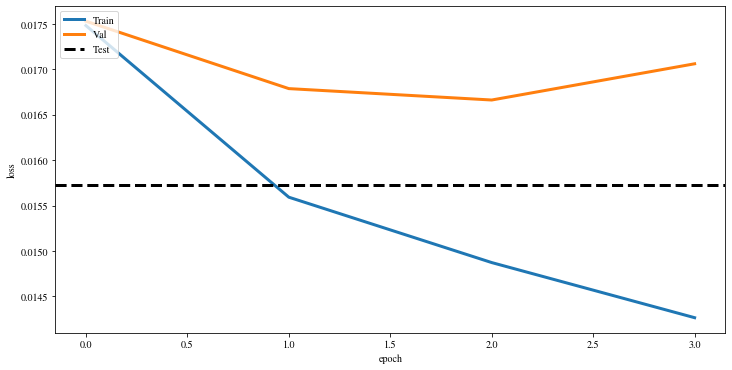

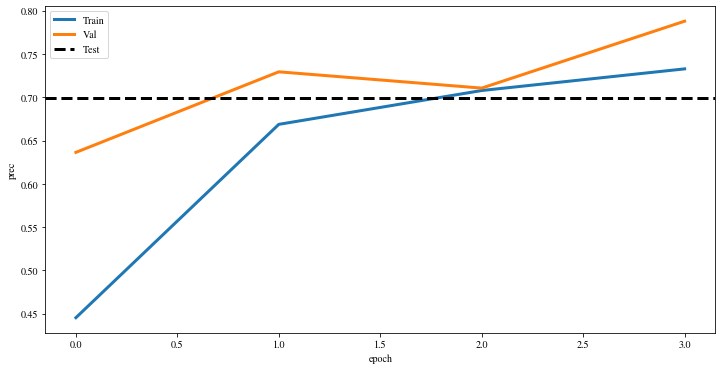

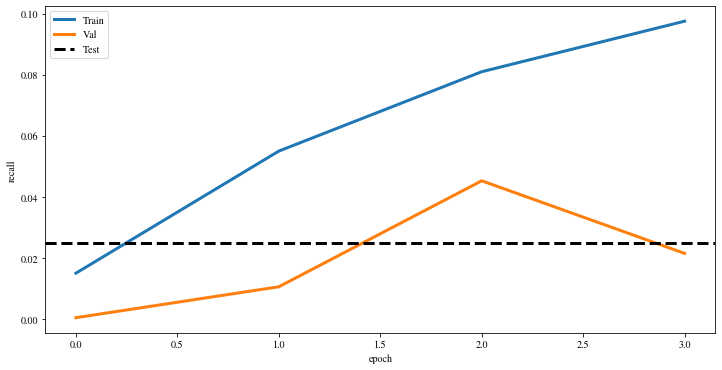

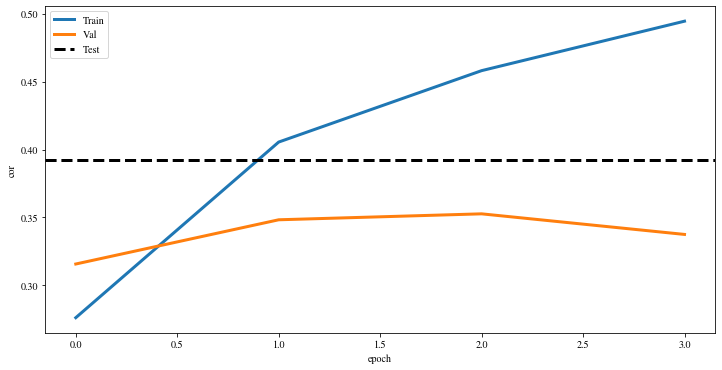

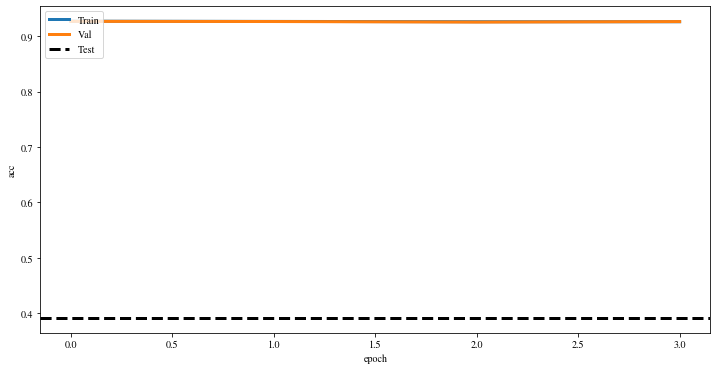

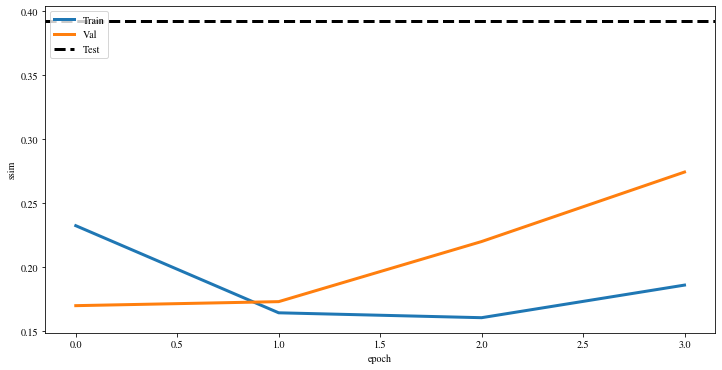

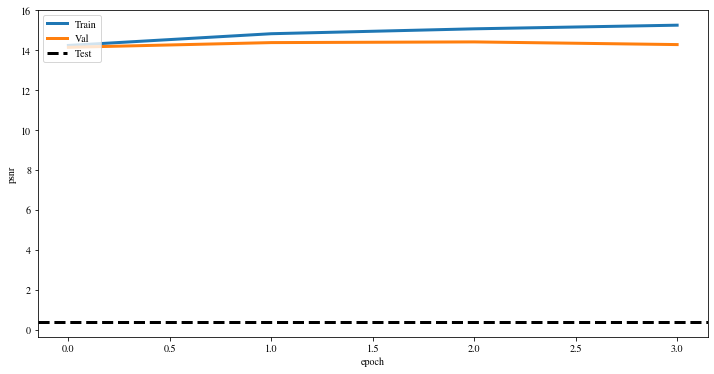

In [6]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.axhline(results['loss'], linestyle='--', color='k', label='Test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss.png')
#files.download('loss.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['prec'], label='Train')
plt.plot(history.history['val_prec'], label='Val')
plt.axhline(results['prec'], linestyle='--', color='k', label='Test')
plt.ylabel('prec')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('prec.png')
#files.download('prec.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.axhline(results['recall'], linestyle='--', color='k', label='Test')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('recall.png')
#files.download('recall.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['cor'], label='Train')
plt.plot(history.history['val_cor'], label='Val')
plt.axhline(results['cor'], linestyle='--', color='k', label='Test')
plt.ylabel('cor')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('cor.png')
#files.download('cor.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Val')
plt.axhline(results['cor'], linestyle='--', color='k', label='Test')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('acc.png')
#files.download('acc.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['ssim'], label='Train')
plt.plot(history.history['val_ssim'], label='Val')
plt.axhline(results['cor'], linestyle='--', color='k', label='Test')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('ssim.png')
#files.download('ssim.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['psnr'], label='Train')
plt.plot(history.history['val_psnr'], label='Val')
plt.axhline(results['cor'], linestyle='--', color='k', label='Test')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('psnr.png')
#files.download('psnr.png')

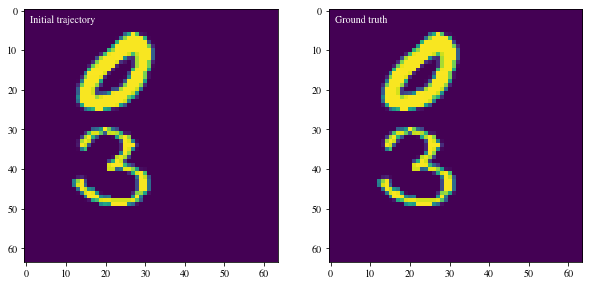

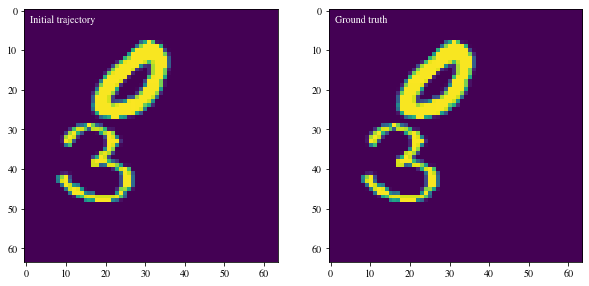

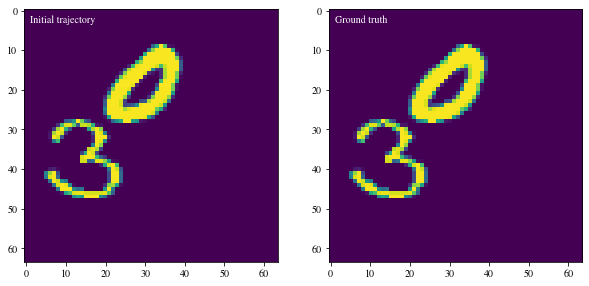

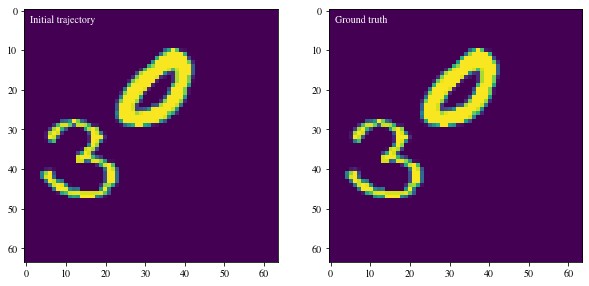

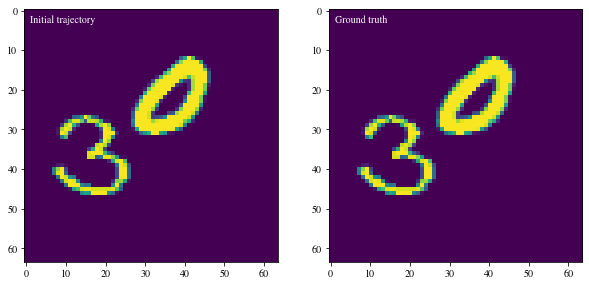

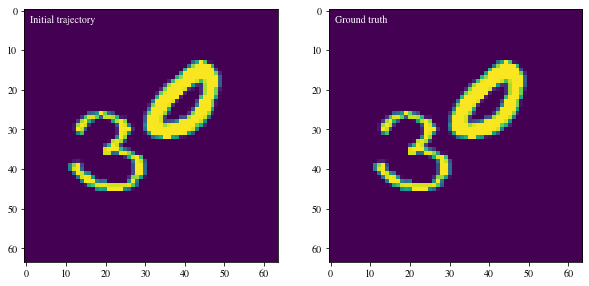

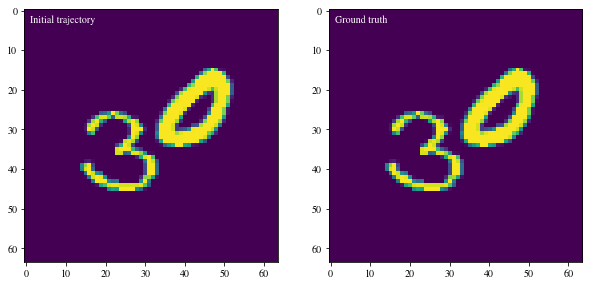

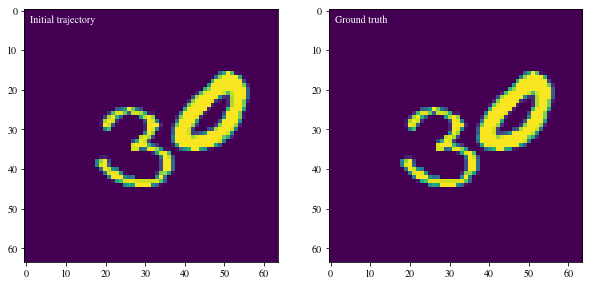

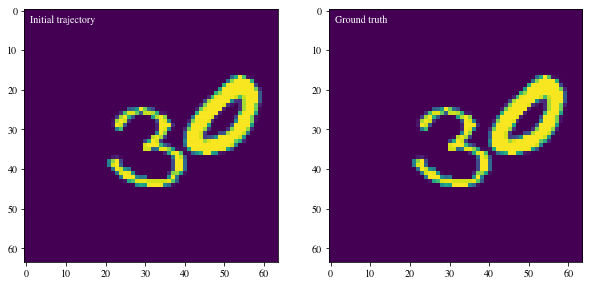

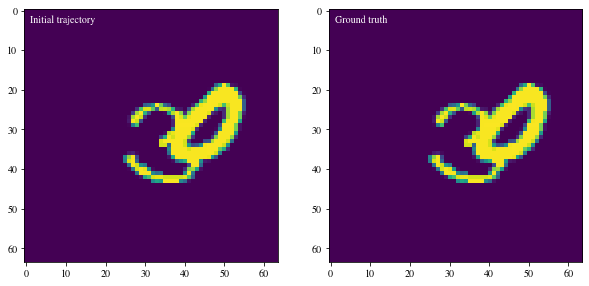

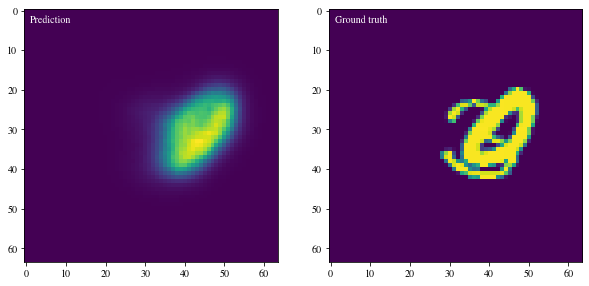

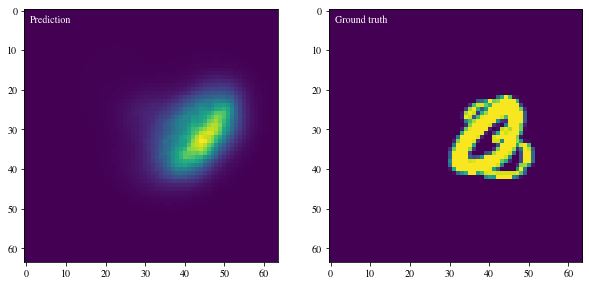

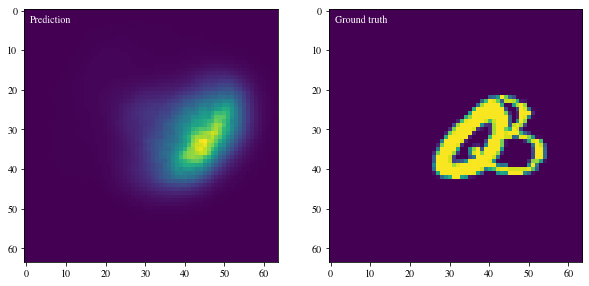

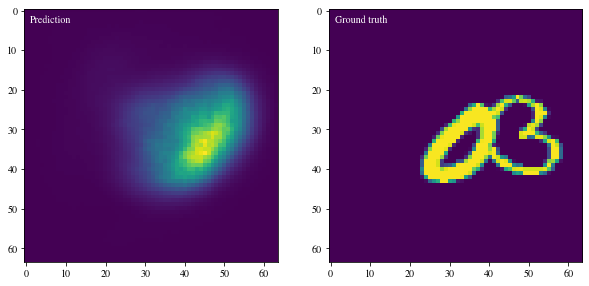

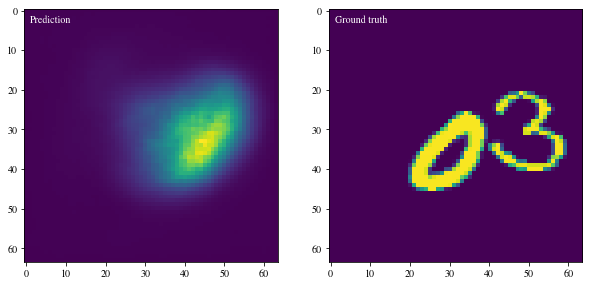

In [7]:
# Plot Train
itest = 1
track_motion = X_motion[itest, :, :, :, :]
track_content = X_content[itest, :, :, :]
track = data_train[itest, :Ninput, :, :, :]
track = np.concatenate((track[None,:,:,:,:], model.predict([track_motion[None, :, :, :, :], track_content[None, :,:,:]])), axis=1)
true_track = data_train[itest, :, :, :, :]
for i in range(Ninput+Noutput):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    if i >= Ninput:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[0, i, :, :, 0])
    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :, 0])
    plt.savefig('train_%i.png' % (i+1))
    #files.download('train_%i.png' % (i+1))

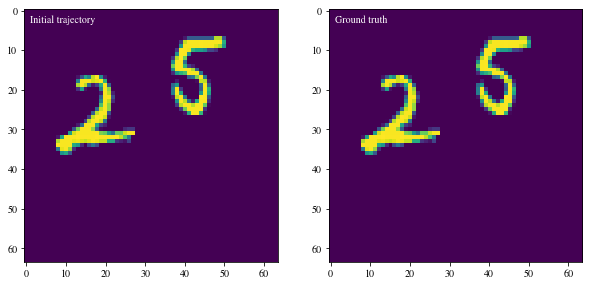

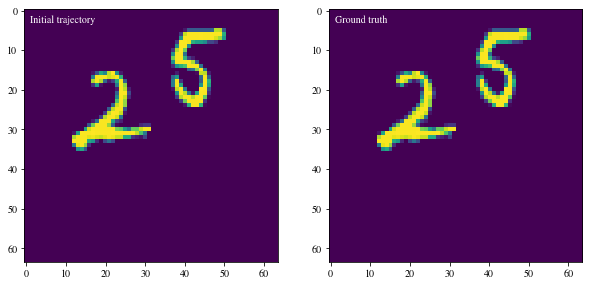

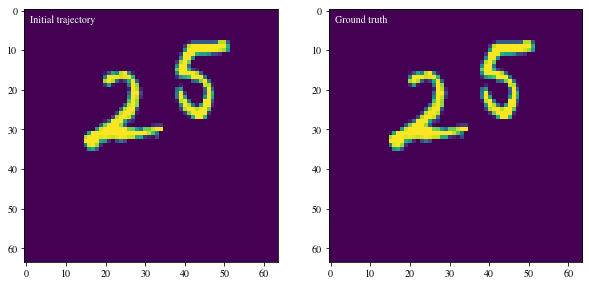

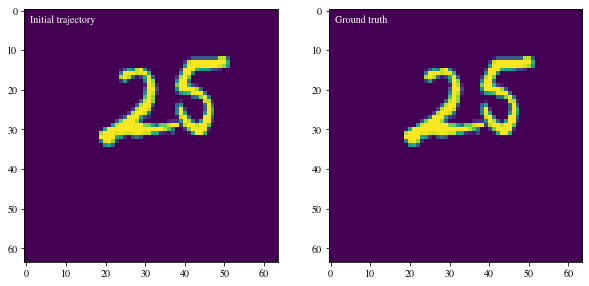

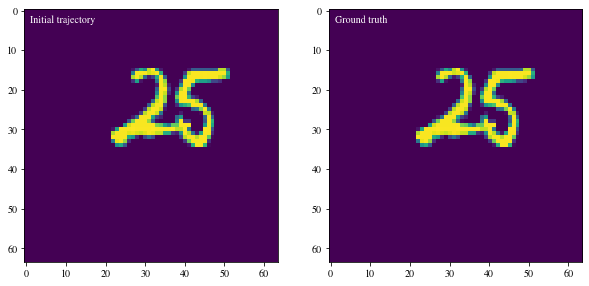

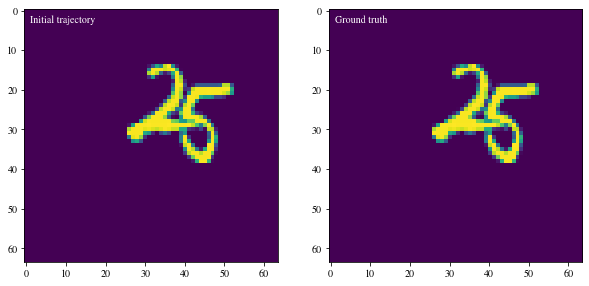

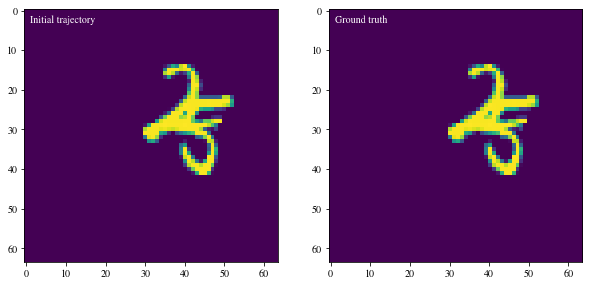

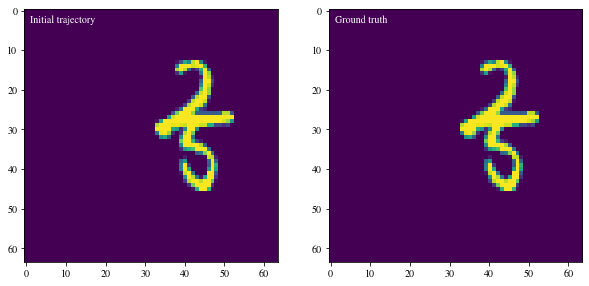

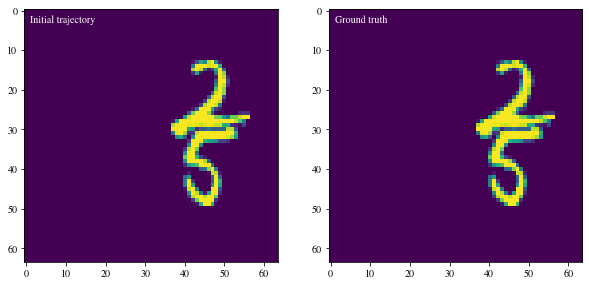

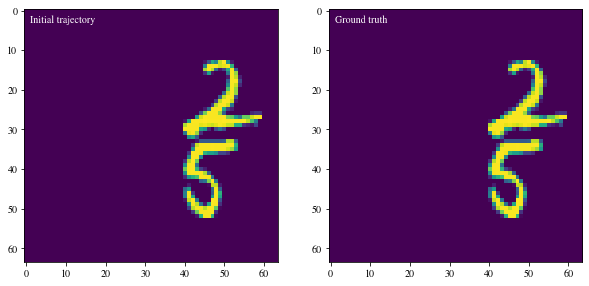

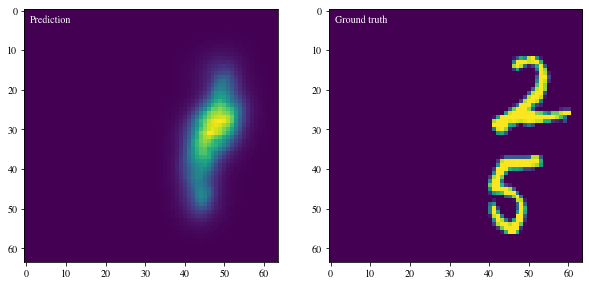

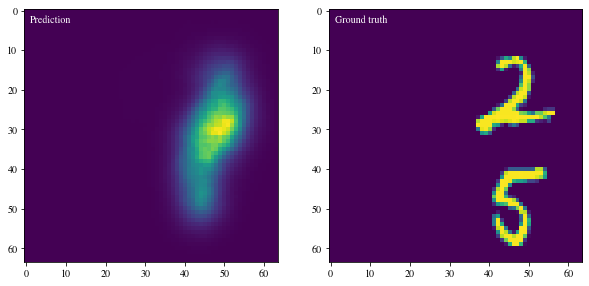

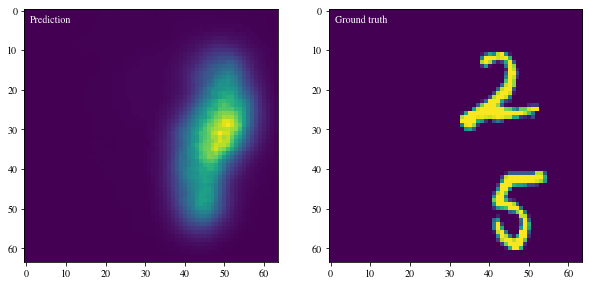

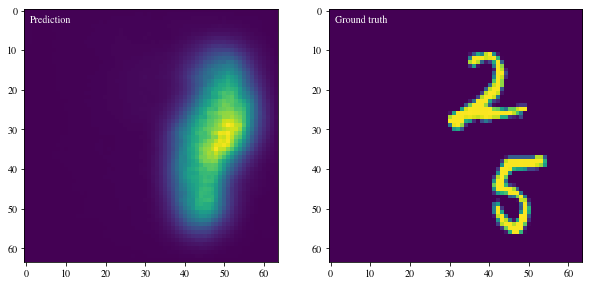

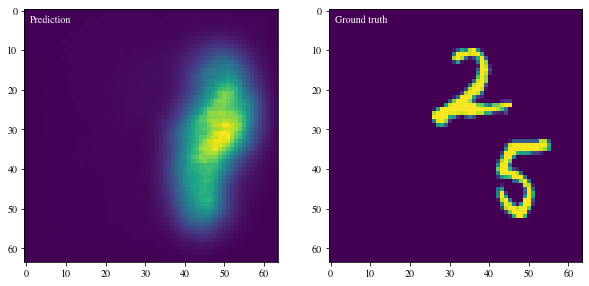

In [8]:
# Plot Test
itest = 1
track_motion = Xtest_motion[itest, :, :, :, :]
track_content = Xtest_content[itest, :, :, :]
track = data_test[itest, :Ninput, :, :, :]
track = np.concatenate((track[None,:,:,:,:], model.predict([track_motion[None, :, :, :, :], track_content[None, :,:,:]])), axis=1)
true_track = data_test[itest, :, :, :, :]
for i in range(Ninput+Noutput):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    if i >= Ninput:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[0, i, :, :, 0])
    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :, 0])
    plt.savefig('test_%i.png' % (i+1))
    #files.download('test_%i.png' % (i+1))